# Problem description

Competition https://www.kaggle.com/c/dont-overfit-ii/overview

The dataset has taken from [here](https://www.kaggle.com/mdmub0587/older-dataset-for-dont-overfit-ii-challenge)
because according to the dataset that is posted in the competition itself, validation does not pass.

# Imports

In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime


from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import *

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

random_state=10

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
path = "/kaggle/input/dont-overfit-ii/"
if not os.path.exists(path):
    path = ""

data = pd.read_csv(path + "train_old.csv", index_col="id")
test = pd.read_csv(path + "test_old.csv", index_col="id")
ss = pd.read_csv(path + "sample_submission.csv", index_col="id")

# EDA

In [4]:
display(data.head(3))
display(data.info())

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211


<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Columns: 301 entries, target to 299
dtypes: float64(301)
memory usage: 589.8 KB


None

In [5]:
display(data.describe())

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,-0.036920,...,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,0.963688,...,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,-2.768000,...,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,-0.689500,...,-0.617000,-0.510500,-0.535750,-0.657000,-0.818500,-0.821000,-0.605500,-0.751250,-0.550000,-0.754250
50%,1.000000,-0.015500,0.057000,0.184000,-0.016500,-0.023000,0.037500,0.060500,0.183500,-0.012500,...,0.067500,0.091000,0.057500,-0.021000,-0.009000,-0.079500,0.009500,0.005500,-0.009000,-0.132500
75%,1.000000,0.677000,0.620750,0.805000,0.720000,0.735000,0.660500,0.783250,0.766250,0.635000,...,0.797250,0.804250,0.631500,0.650250,0.739500,0.493000,0.683000,0.794250,0.654250,0.503250
max,1.000000,2.567000,2.419000,3.392000,2.771000,2.901000,2.793000,2.546000,2.846000,2.512000,...,2.865000,2.801000,2.736000,2.596000,2.226000,3.131000,3.236000,2.626000,3.530000,2.771000


In [6]:
# Check NA
data.isna().any().sum()

0

In [7]:
# Check class distribution
data["target"].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

#### Data params

In [8]:
df = data.drop(["target"], axis=1).copy()
print(">>>Mean value test<<<")
for col in df.columns:
    feature = df.loc[:, col]
    f_desc = feature.describe()
    if np.abs(f_desc["mean"])>0.2:
        print("Feature {0}: mean isnt equal to zero. Mean: {1:.3}".format(col, f_desc["mean"]))
        
print("\n>>>Std value test<<<")
for col in df.columns:
    feature = df.loc[:, col]
    f_desc = feature.describe()
    if np.abs(1 - f_desc["std"])>0.2:
        print("Feature {0}: std isnt equal to 1. Std: {1:.3}".format(col, f_desc["std"]))

print("\n>>>Normality test<<<")
for col in df.columns:
    feature = df.loc[:, col]
    stat, p_val = stats.kstest(feature, 'norm')
    if p_val<0.05:
        print("Feature {0} has non-normal distribution. p-value: {1:.4}".format(col, p_val))
        
print("\n>>>Correlation test<<<")   
cm = df.corr()
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>0.5)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print("Features with hi correlations: {}".format(high_corr_var))
    

print("\n>>>Samples with outliars (std>3)<<<")   
mask = df > 3
mask = mask.any(axis=1)
print("Total: %d" % mask.sum())

>>>Mean value test<<<
Feature 228: mean isnt equal to zero. Mean: -0.2

>>>Std value test<<<

>>>Normality test<<<
Feature 2 has non-normal distribution. p-value: 0.006165
Feature 25 has non-normal distribution. p-value: 0.0307
Feature 33 has non-normal distribution. p-value: 0.02734
Feature 34 has non-normal distribution. p-value: 0.008452
Feature 37 has non-normal distribution. p-value: 0.003639
Feature 119 has non-normal distribution. p-value: 0.02118
Feature 147 has non-normal distribution. p-value: 0.01391
Feature 157 has non-normal distribution. p-value: 0.03899
Feature 167 has non-normal distribution. p-value: 0.02312
Feature 186 has non-normal distribution. p-value: 0.01226
Feature 193 has non-normal distribution. p-value: 0.03651
Feature 228 has non-normal distribution. p-value: 0.01123
Feature 234 has non-normal distribution. p-value: 0.01942
Feature 241 has non-normal distribution. p-value: 0.01978
Feature 261 has non-normal distribution. p-value: 0.01588
Feature 282 has non

## 👉 Conclusion

- The dataset has a small number of samples (250), but a large number of features (300).
 - Classes are not balanced.
 - There are no missing values.
 - All attributes are real.
 - No high cross-correlation features.
 - Features are standardized - mean = 0, standard deviation = 1.
 - 94% of features have a normal distribution.
 - 87 samples contain deviations of more than 3 sigma in at least one feature. Removing them will greatly reduce the sample size.
 
We need to take measures to prevent overfitting - we will reduce the dimension and apply cross-validation.
Since almost all features have a normal distribution, we can apply statistical tests to test hypotheses.

Not all machine learning models can be used when there are not enough samples (eg XGBoost). This somewhat limits the choice.
 

# Dataset

In [9]:
y = data["target"].astype(int)
X = data.drop(["target"], axis=1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
#poly = PolynomialFeatures(interaction_only=True)
#X_poly = pd.DataFrame(poly.fit_transform(X), index=X.index)

# Prepare the infrastructure for training

- Because we have a very small data sample, then we probably won’t be able to split the dataset into train, validation and test samples. We will work with the results of cross-validation. Let's apply RepeatedStratifiedKFold to get more stable results.

- To exclude "Data Leakage", all data transformations will be performed after splitting into train and test through the pipeline.

- To search for the optimal values of hyperparameters, we use hyperOpt.

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt import rand
from functools import partial
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, 
#from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer

In [11]:
def pipe_factory_basic(space, Model):
    model = Model(**space["model"]) 
    scaler = StandardScaler()
    pipe = Pipeline([("scaler", scaler), ('model', model)])
    return pipe

In [12]:
def objective(space, X, y, Model, pipe_factory):
    pipe = pipe_factory(space, Model)
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
    scores = []
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict_proba(X_test)
        scores.append(-roc_auc_score(y_test, y_pred[:, 1:]))
    return {'loss': np.mean(scores), 'status': STATUS_OK, "pipe": pipe}

def optimize_hyperparam(X, y, Model, pipe_factory, space_model, space_obj, iters=50):
    print(Model.__name__)
    trials = Trials()
    space = {"model": space_model, "obj": space_obj}
    fmin_objective = partial(objective, X=X, y=y, Model=Model, pipe_factory=pipe_factory)
    best = fmin(fn=fmin_objective, 
                space=space, 
                trials=trials, 
                algo=tpe.suggest, 
                max_evals=iters, 
                rstate=np.random.RandomState(random_state),
                verbose=1)
    print("----------------")
    best_params = space_eval(space, best)
    result = {
        "pipe": pipe_factory(best_params, Model).fit(X, y),
        "details":{
            "pipe_factory": pipe_factory, 
            "model": Model,
            "params": best_params,
        }
    }
    
    return result

In [13]:
def submission(trained, X_test, suffix=""):
    y_pred = trained["pipe"].predict_proba(X_test)
    
    subm = pd.read_csv(path + "sample_submission.csv", index_col="id")
    subm["target"] = y_pred[:, 1]
    sumbission_name = "Subm - {0} | {1} | {2}".format(
        trained["details"]["model"].__name__, 
        trained["details"]["pipe_factory"].__name__,
        suffix)
    subm.to_csv(sumbission_name+".csv")
    return subm
    

Let's try some models. Let's declare the parameter space for finding the optimal ones.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [15]:

lr_params_l2 = {
    'penalty': 'l2',
    'solver': 'lbfgs',
    'C': hp.uniform('C', 0.00001,10),
    "class_weight":"balanced", 
    "random_state":random_state
}

lr_params_l1 = {
    'penalty': 'l1',
    'solver': 'liblinear',
    'C': hp.uniform('C', 0.00001,10),
    "class_weight":"balanced", 
    "random_state":random_state
}

knc_params = {
    'n_neighbors': hp.choice('n_neighbors',np.arange(2, 10)),
    'weights': hp.choice('weights',['uniform', 'distance']),
    'p': hp.choice('p',np.arange(1, 4)),
}

rfc_params = {
    'n_estimators': hp.choice('n_estimators',np.arange(5,150)),
    'criterion': hp.choice('criterion',["gini", "entropy"]),
    'max_depth': hp.choice('max_depth',np.arange(1,15)),
    'min_samples_split': hp.choice('min_samples_split',np.arange(2,10)),
    "class_weight":"balanced", 
    "random_state":random_state,
    "n_jobs": -1
}

svc_params = {
    'C': hp.uniform('C', 0.00001,10),
    'kernel': hp.choice('kernel',["linear", "poly", "rbf", "sigmoid"]),
    'probability': True,
    "class_weight":"balanced", 
    "random_state":random_state
}

In [16]:
logreg_l1_basic = optimize_hyperparam(X, y, LogisticRegression, pipe_factory_basic, lr_params_l1, None)
logreg_l2_basic = optimize_hyperparam(X, y, LogisticRegression, pipe_factory_basic, lr_params_l2, None)
svc_basic = optimize_hyperparam(X, y, SVC, pipe_factory_basic, svc_params, None)
rfc_basic = optimize_hyperparam(X, y, RandomForestClassifier, pipe_factory_basic, rfc_params, None)
knc_basic = optimize_hyperparam(X, y, KNeighborsClassifier, pipe_factory_basic, knc_params, None)

LogisticRegression
100%|██████████| 50/50 [00:40<00:00,  1.23trial/s, best loss: -0.7972222222222223]
----------------
LogisticRegression
100%|██████████| 50/50 [00:41<00:00,  1.21trial/s, best loss: -0.7505555555555554]
----------------
SVC
100%|██████████| 50/50 [01:28<00:00,  1.76s/trial, best loss: -0.7541666666666665]
----------------
RandomForestClassifier
100%|██████████| 50/50 [04:52<00:00,  5.84s/trial, best loss: -0.7240277777777776]
----------------
KNeighborsClassifier
100%|██████████| 50/50 [00:41<00:00,  1.20trial/s, best loss: -0.6365972222222223]
----------------


In [18]:
subm_logreg_l1_basic = submission(logreg_l1_basic, test, suffix="l1") #0.848  
subm_logreg_l2_basic = submission(logreg_l2_basic, test, suffix="l2") #0.746
subm_svc_basic = submission(svc_basic, test)   #0.743

We got the basic prediction values.

Suddenly, logistic regression with L1 regularizer gave the best result so far - both in terms of cross-validation numbers and on the test set (AUC 0.848).

# Select k best

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import power_transform

In [20]:
def pipe_factory_skb(space, Model):
    model = Model(**space["model"]) 
    scaler = StandardScaler()
    skb = SelectKBest(f_classif, **space["obj"])
    pipe = Pipeline([("scaler", scaler), ('skb', skb), ('model', model)])
    return pipe

skb_params = {"k": hp.choice('k',np.arange(10,50))}

In [21]:
logreg_l1_skb = optimize_hyperparam(X, y, LogisticRegression, pipe_factory_skb, lr_params_l1, skb_params)
logreg_l2_skb = optimize_hyperparam(X, y, LogisticRegression, pipe_factory_skb, lr_params_l2, skb_params)
svc_skb = optimize_hyperparam(X, y, SVC, pipe_factory_skb, svc_params, skb_params)
rfc_skb = optimize_hyperparam(X, y, RandomForestClassifier, pipe_factory_skb, rfc_params, skb_params)
knc_skb = optimize_hyperparam(X, y, KNeighborsClassifier, pipe_factory_skb, knc_params, skb_params)

LogisticRegression
100%|██████████| 50/50 [00:29<00:00,  1.68trial/s, best loss: -0.8022222222222223]
----------------
LogisticRegression
100%|██████████| 50/50 [00:34<00:00,  1.43trial/s, best loss: -0.7905555555555555]
----------------
SVC
100%|██████████| 50/50 [01:02<00:00,  1.25s/trial, best loss: -0.7869444444444446]
----------------
RandomForestClassifier
100%|██████████| 50/50 [04:28<00:00,  5.37s/trial, best loss: -0.7584722222222221]
----------------
KNeighborsClassifier
100%|██████████| 50/50 [00:28<00:00,  1.77trial/s, best loss: -0.715486111111111] 
----------------


In [22]:
subm_logreg_l1_skb = submission(logreg_l1_skb, test, suffix="l1") #0.84  
subm_logreg_l2_skb = submission(logreg_l2_skb, test, suffix="l2") #0.816 
subm_svc_skb = submission(svc_skb, test)  # 0.787

On cross-validation, the score grew up, but when checking the results on kaggle.com, it slightly decreased.

# Polynomial features
It turns out 45k features. When selecting by SelectKBest, we overfit.

# PCA
Nothing interesting

# Select from model

In [23]:
from sklearn.feature_selection import SelectFromModel

In [24]:
def pipe_factory_sfm(space, Model):
    est = LogisticRegression(**logreg_l1_basic["details"]["params"]["model"])
    selector = SelectFromModel(estimator=est, **space["obj"])
    model = Model(**space["model"]) 
    scaler = StandardScaler()
    pipe = Pipeline([("scaler", scaler), ("selector", selector),('model', model)])
    return pipe

sfm_params = {"max_features": hp.choice('max_features',np.arange(1,50))}

logreg_l1_sfm = optimize_hyperparam(X, y, LogisticRegression, pipe_factory_sfm, lr_params_l1, sfm_params)
logreg_l2_sfm = optimize_hyperparam(X, y, LogisticRegression, pipe_factory_sfm, lr_params_l2, sfm_params)
svc_sfm = optimize_hyperparam(X, y, SVC, pipe_factory_sfm, svc_params, sfm_params)
rfc_sfm = optimize_hyperparam(X, y, RandomForestClassifier, pipe_factory_sfm, rfc_params, sfm_params)
knc_sfm = optimize_hyperparam(X, y, KNeighborsClassifier, pipe_factory_sfm, knc_params, sfm_params)

LogisticRegression
100%|██████████| 50/50 [00:32<00:00,  1.54trial/s, best loss: -0.8023611111111112]
----------------
LogisticRegression
100%|██████████| 50/50 [00:37<00:00,  1.35trial/s, best loss: -0.7888888888888889]
----------------
SVC
100%|██████████| 50/50 [01:16<00:00,  1.52s/trial, best loss: -0.7888888888888892]
----------------
RandomForestClassifier
100%|██████████| 50/50 [04:25<00:00,  5.32s/trial, best loss: -0.7741666666666666]
----------------
KNeighborsClassifier
100%|██████████| 50/50 [00:32<00:00,  1.56trial/s, best loss: -0.745763888888889] 
----------------


In [25]:
subm_logreg_l1_sfm = submission(logreg_l1_sfm, test, suffix="l1") #0.844
subm_logreg_l2_sfm = submission(logreg_l2_sfm, test, suffix="l2") #0.844
subm_svc_skb = submission(svc_sfm, test)  # 0.845

When selecting features from the logistic regression with the L1 regularizer, the cross-validation values did not change much, but the numbers on the test sample for the log regression (L2) and SVC grew up to the level of the log regression (L1).

# Remove outliars

In [26]:
def plot_hist(idx, X, y, offset=0, n_feats=6, n_cols=3):
    n_rows = int(np.ceil(n_feats/n_cols))
    fig, ax = plt.subplots(figsize=(13, 2.5*n_rows), ncols=n_cols, nrows=n_rows )
    fig.tight_layout()
    for i in range(n_feats):
        feat = idx[i+offset*n_feats]
        xi, yi = i//n_cols, i%n_cols   
        if n_rows==1:
            plt_idx = yi
        else:
            plt_idx = (xi, yi)
        
        ax[plt_idx] = sns.histplot(x=X.iloc[:, feat], hue=y, bins=30, element="step", stat="density", kde=True, ax=ax[plt_idx])  

In [27]:
est = LogisticRegression(**logreg_l1_basic['details']['params']["model"]).fit(X,y)
idx_lr = np.argsort(-np.abs(est.coef_[0]))
print(idx_lr[:10])
print(est.coef_[0][idx_lr[:5]])

[ 33  65 217  91 117 199  73 295 258 133]
[ 0.63791379  0.45831498 -0.28484532 -0.26893168 -0.19290289]


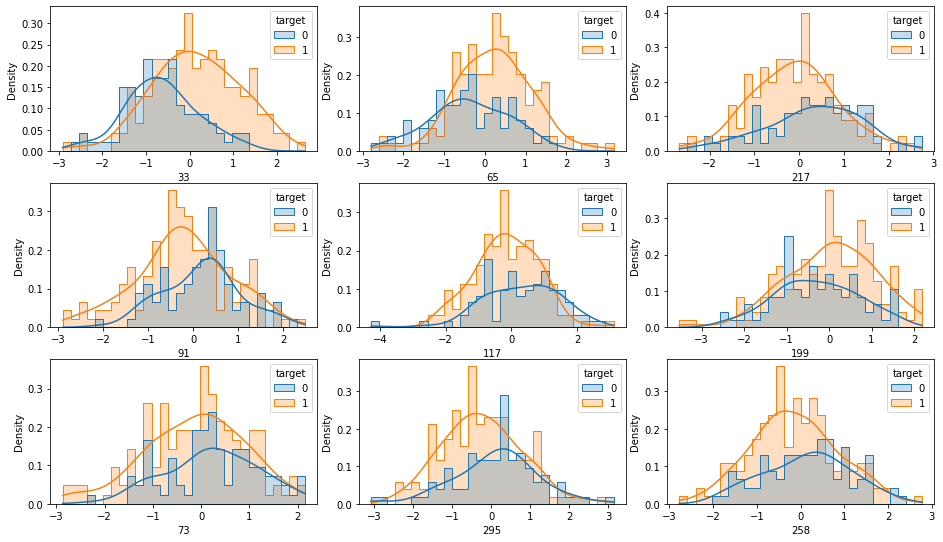

In [28]:
plot_hist(idx_lr, X, y, offset=0, n_feats=9, n_cols=3)

In [29]:
drop_idx = []
drop_idx += list(X[(y.values==1) & (X.loc[:, '33']<-2.5)].index)
drop_idx += list(X[(y.values==1) & (X.loc[:, '65']<-2.5)].index)
drop_idx += list(X[(y.values==1) & (X.loc[:, '217']>2.4)].index)
drop_idx += list(X[(y.values==0) & (X.loc[:, '217']<-2.2)].index)
drop_idx += list(X[(y.values==0) & (X.loc[:, '117']<-2.5)].index)
drop_idx += list(X[(y.values==1) & (X.loc[:, '199']<-3)].index)
drop_idx += list(X[(y.values==1) & (X.loc[:, '295']>2.5)].index)
drop_idx += list(X[(y.values==1) & (X.loc[:, '258']>2.5)].index)

print(len(set(drop_idx)))

10


In [30]:
X.loc[drop_idx, idx_lr[:10].astype(str)]

,33,65,217,91,117,199,73,295,258,133
id,,,,,,,,,,
23,-2.913,-0.927,1.020,0.347,0.668,1.670,-0.442,0.130,-1.498,-0.818
50,-1.048,-2.516,-0.010,0.406,0.681,-0.453,-0.084,-0.503,-0.311,-0.267
44,1.066,-0.279,2.434,-0.581,-1.998,0.929,-0.830,-0.580,-1.078,-0.966
153,-0.808,-0.219,-2.358,0.383,-0.051,-0.713,-0.379,1.007,0.841,-1.537
181,-0.952,-1.182,0.450,1.424,-2.690,-0.131,-1.468,0.670,2.253,-1.299
245,-1.416,-0.330,0.223,0.369,-4.270,0.061,0.274,-0.243,-1.359,0.204
146,0.348,0.002,-1.185,-0.561,-0.917,-3.521,-0.119,0.023,-0.324,1.278
152,0.613,-0.352,-1.097,-1.544,-1.707,-3.165,0.214,-0.798,-0.170,-0.184
112,1.535,0.294,2.100,-1.352,-0.674,0.747,-0.149,2.902,0.143,0.340


In [31]:
X3 = X.drop(set(drop_idx))
y3 = y.drop(set(drop_idx))

logreg_l1_basic_x3 = optimize_hyperparam(X3, y3, LogisticRegression, pipe_factory_basic, lr_params_l1, None)
subm_logreg_l1_basic_x3 = submission(logreg_l1_basic_x3, test, suffix="l1-outliers_x3") #0.848

LogisticRegression
100%|██████████| 50/50 [00:37<00:00,  1.32trial/s, best loss: -0.8229074074074074]
----------------


Careful removal of values that are out of the general range allowed us to slightly increase the AUC on cross-validation. And did not lead to changes in the test sample.

Let's leave it like that. Further "cleansing" can go to the detriment.